In [70]:
import pandas as pd
import ijson
import numpy as np
import json
import io
import os
import matplotlib.pyplot as plt

In [3]:
## We choose data from Las Vegas as an illustrative example.

data = pd.read_csv('LasVegas_tips_after2017.csv')

In [4]:
data.head(5)

,Unnamed: 0,business_id,text,date,attributes,categories,city,name,stars,review_count
0,8,KPgyqG3MyFUDK7GRbUg51A,Kelly Paun was so full of knowledge and was so...,2017-03-23,NaN,"Landmarks & Historical Buildings, Travel Servi...",Las Vegas,Pink Jeep Tours,4.5,136
1,20,JtNVcqioJhS8GZ-If30oHg,Make sure you sign up for Emerald club before ...,2018-03-29,NaN,"Automotive, Hotels & Travel, Car Rental",Las Vegas,National Car Rental,4.0,224
2,34,gh6__q2WXFuyN8gt6VAnWw,Very delicious food with very fast delivery!,2017-09-24,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...","Seafood, Restaurants, Steakhouses, Greek, Fren...",Las Vegas,Vila Algarve,4.5,189
3,55,gh6__q2WXFuyN8gt6VAnWw,Amazing Portuguese food! Linguica (chirizo) is...,2017-12-11,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...","Seafood, Restaurants, Steakhouses, Greek, Fren...",Las Vegas,Vila Algarve,4.5,189
4,56,gh6__q2WXFuyN8gt6VAnWw,All the way from Porto portugal lost off love!...,2018-04-10,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...","Seafood, Restaurants, Steakhouses, Greek, Fren...",Las Vegas,Vila Algarve,4.5,189


In [5]:
data.dtypes

Unnamed: 0        int64
business_id      object
text             object
date             object
attributes       object
categories       object
city             object
name             object
stars           float64
review_count      int64
dtype: object

## Define a categorical variable

In [6]:
data.index

RangeIndex(start=0, stop=65280, step=1)

In [7]:
stars = np.array(data['stars'])

In [8]:
##1.0 means good; 0.0 means not good, bad ...
stars[stars<4.0] = 0.0
stars[stars>=4.0] = 1.0
data['class'] = stars

In [9]:
data.head(15);

In [66]:
data[data['stars'].astype('float64')<4.0].count()

Unnamed: 0      21364
business_id     21364
text            21364
date            21364
attributes      20527
categories      21348
city            21364
name            21364
stars           21364
review_count    21364
class           21364
tips_stars      21364
dtype: int64

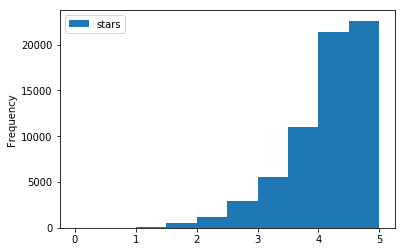

In [75]:
data[['stars']].astype('float64').plot(kind='hist',bins=[0,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0])
plt.show()

### A glimpse onto the statistics of the class variable

In [10]:
data['stars'].describe()

count    65280.000000
mean         3.908058
std          0.703868
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: stars, dtype: float64

In [11]:
data['class'].describe()

count    65280.000000
mean         0.672733
std          0.469219
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: class, dtype: float64

### Combine the tips column with the stars column

In [12]:
# Create a new column which combines "text" and "stars"

# Turn stars into strings, add a space in front of each item

data['stars'] = data['stars'].map(str).apply(lambda x: ' ' + x);

data['tips_stars'] = data["text"] + data['stars']

In [13]:
data.iloc[98]['tips_stars']

"Park valet. It'll be the best $20 you spend because it gives you free valet parking nearly everywhere else (like Bellagio). Any MGM resort on the Strip is included, and there's many. 3.0"

### Split the dataset into training set and test set 

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_set, test_set = train_test_split(
...     data, test_size=0.33, random_state=42)

### tf-idf

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer =  TfidfVectorizer(max_features=1200,stop_words='english',ngram_range=(1,3))

In [17]:
vectorizer.fit(data['tips_stars'].values.astype('U'))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1200, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [18]:
## The train set are tf-idfed.

train_tfidf = vectorizer.transform(train_set['tips_stars'].values.astype('U'))

In [19]:
test_tfidf = vectorizer.transform(test_set['tips_stars'].values.astype('U'))

In [20]:
train_tfidf.shape

(43737, 1200)

In [21]:
test_tfidf.shape

(21543, 1200)

In [22]:
#print(vectorizer.get_feature_names())

In [23]:
#print(test_tfidf)

In [24]:
vectorizer.get_stop_words()

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

### K Means

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from sklearn_pandas import DataFrameMapper

## The output of K_Means is an array of labels. 

In [26]:
K = 16
KMeans_model = KMeans(n_clusters=K, init='k-means++', max_iter=100, n_init=1)
KMeans_model.fit(train_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=16, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [27]:
KMeans_model.predict(train_tfidf)

array([10,  1,  1, ...,  1,  0,  1], dtype=int32)

In [28]:
order_centroids = KMeans_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(K):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Cluster 0:
 amazing
 food
 amazing food
 service
 food amazing
 amazing service
 great
 place
 place amazing
 service amazing
Cluster 1:
 awesome
 service
 don
 food
 time
 great
 free
 open
 nice
 try
Cluster 2:
 helpful
 staff
 friendly
 friendly helpful
 super
 great
 nice
 awesome
 knowledgeable
 place
Cluster 3:
 best
 vegas
 ve
 las vegas
 las
 place
 best place
 food
 hands
 pizza
Cluster 4:
 love
 love place
 place
 love love
 food
 great
 love food
 love love love
 love place great
 service
Cluster 5:
 place
 great place
 great
 awesome
 nice
 favorite
 place great
 nice place
 awesome place
 favorite place
Cluster 6:
 just
 like
 don
 place
 food
 good
 time
 service
 great
 ok
Cluster 7:
 friendly
 staff
 friendly staff
 great
 service
 friendly service
 fast
 staff friendly
 super
 clean
Cluster 8:
 good
 good food
 food
 food good
 service
 good service
 food good service
 good food good
 service good
 great
Cluster 9:
 happy
 happy hour
 hour
 great
 6pm
 menu
 7pm
 drink

## Dimension Reducing: PCA

In [29]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

n_components = 50

#truncatedSVD 

In [30]:
svd = TruncatedSVD(n_components)

In [31]:
svd.fit(train_tfidf)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0)

In [32]:
svd.transform(train_tfidf)

array([[ 1.54680731e-01,  2.21569374e-01,  3.85014932e-01, ...,
         1.99489564e-02,  1.08813881e-01,  8.32471849e-02],
       [ 3.89008979e-02,  2.52415706e-02,  5.06788541e-03, ...,
         2.60678575e-03,  8.62867116e-02, -7.67336198e-03],
       [ 9.43313686e-03,  4.42713126e-03,  3.26940768e-04, ...,
         8.00110514e-03, -5.60688836e-03,  1.03998829e-02],
       ...,
       [ 4.55151913e-02,  9.14808180e-03, -5.32360596e-03, ...,
        -5.18205453e-02, -1.05626177e-02,  2.25053820e-02],
       [ 1.22982697e-01,  1.73239297e-01, -7.08101608e-02, ...,
        -3.40603832e-02, -3.40678171e-02, -3.23134313e-02],
       [ 5.13251702e-02,  2.03386817e-02, -1.81931796e-03, ...,
         6.29480149e-02,  2.65550196e-02, -1.36871036e-02]])

In [33]:
svd.fit_transform(train_tfidf)

array([[ 1.54681157e-01,  2.21562849e-01,  3.85009785e-01, ...,
         6.52188445e-03,  2.73619660e-01, -1.03699651e-02],
       [ 3.89008098e-02,  2.52358458e-02,  5.06371457e-03, ...,
         9.73434095e-04, -1.71409847e-02, -6.82292652e-03],
       [ 9.43321735e-03,  4.42740112e-03,  3.28558718e-04, ...,
         2.10239303e-03,  1.33886916e-03,  9.48828301e-03],
       ...,
       [ 4.55145600e-02,  9.14512728e-03, -5.32043927e-03, ...,
        -3.79494537e-02,  1.01533186e-03, -2.49205239e-02],
       [ 1.22980789e-01,  1.73223238e-01, -7.08095693e-02, ...,
         5.38590145e-02, -1.02565786e-01, -3.06210549e-02],
       [ 5.13248816e-02,  2.03374707e-02, -1.80845826e-03, ...,
        -5.36471106e-03,  2.47689008e-01, -2.48755230e-02]])

In [34]:
train_tfidf

<43737x1200 sparse matrix of type '<class 'numpy.float64'>'
	with 231554 stored elements in Compressed Sparse Row format>

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
train_target = train_set["class"]

In [37]:
clf = LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial').fit(train_tfidf,train_target)

In [38]:
clf.predict(train_tfidf)

array([1., 1., 1., ..., 1., 1., 0.])

In [39]:
clf.predict(test_tfidf)

array([1., 1., 1., ..., 1., 1., 0.])

In [40]:
clf.score(train_tfidf, train_target)

0.7227747673594439

In [41]:
clf.score(test_tfidf,test_set["class"])

0.700505964814557

In [42]:
train_set.count()

Unnamed: 0      43737
business_id     43737
text            43736
date            43737
attributes      42609
categories      43722
city            43737
name            43737
stars           43737
review_count    43737
class           43737
tips_stars      43736
dtype: int64

In [43]:
train_set[train_set["class"]==1.0].count()

Unnamed: 0      29505
business_id     29505
text            29504
date            29505
attributes      28946
categories      29501
city            29505
name            29505
stars           29505
review_count    29505
class           29505
tips_stars      29504
dtype: int64

In [44]:
29505/43737

0.6746004527059469

### Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

/Users/xudou/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [46]:
RF_clf = RandomForestClassifier(n_estimators=10, max_depth=4,random_state=42)

In [47]:
RF_clf.fit(train_tfidf,train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [48]:
RF_clf.score(train_tfidf,train_target)

0.6746233166426595

In [49]:
RF_clf.score(test_tfidf,test_set["class"])

0.6689411873926565

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

documents = ["This little kitty came to play when I was eating at a restaurant.",
             "Merley has the best squooshy kitten belly.",
             "Google Translate app is incredible.",
             "If you open 100 tab in google you get a smiley face.",
             "Best cat photo I've ever taken.",
             "Climbing ninja cat.",
             "Impressed with google map feedback.",
             "Key promoter extension for Google Chrome."]

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)


 

In [ ]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)



In [ ]:
print("Top terms per cluster:")


In [ ]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print



In [ ]:
print("\n")
print("Prediction")

Y = vectorizer.transform(["chrome browser to open."])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["My cat is hungry."])
prediction = model.predict(Y)
print(prediction)